In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline


In [ ]:
! pip install -q transformers[sentencepiece] fastbook fastai ohmeow-blurr nbdev


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 24.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 38.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.1/81.1 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.8/64.8 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 30.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 36.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 55.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 55.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 518.9/518.9 kB 37.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.5/887.5 MB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:

import torch
from transformers import AutoModelForSequenceClassification, AutoConfig
from fastai.text.all import *
from blurr.text.data.all import *
from blurr.text.modeling.all import *

/usr/local/lib/python3.10/dist-packages/blurr/text/modeling/question_answering.py:31: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  squad_metric = load_metric("squad")


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/MASTER

/content/drive/MyDrive/MASTER


MyDrive  Shareddrives


In [ ]:
df = pd.read_csv("series_list4.csv")
df.head()

,title,genres,description
0,The Witcher (2019– ),"['Action', 'Adventure', 'Drama']","Geralt of Rivia, a solitary monster hunter, struggles to find his place in a world where people often prove more wicked than beasts."
1,The Bear (2022– ),"['Comedy', 'Drama']",A young chef from the fine dining world returns to Chicago to run his family's sandwich shop.
2,Special Ops: Lioness (2023– ),"['Action', 'Drama', 'Thriller']","Joe attempts to balance her personal and professional life as the tip of the spear in the CIA's war on terror. She enlists Cruz, a Marine Raider, as an undercover operative in the Lioness Program."
3,Suits (2011–2019),"['Comedy', 'Drama']","On the run from a drug deal gone bad, brilliant college dropout Mike Ross finds himself working with Harvey Specter, one of New York City's best lawyers."
4,Hijack (2023– ),"['Drama', 'Thriller']","A plane from Dubai to London is hijacked over a 7-hour flight, while authorities on the ground scramble for answers."


In [ ]:
df.shape


(24950, 3)

In [ ]:
df = df.dropna().reset_index(drop=True)
df.shape

(24950, 3)

In [ ]:
genres_list = df.genres.to_list()
genre_count = {}
for genres in genres_list:
  genre_list = eval(genres)
  for genre in genre_list:
    if genre in genre_count.keys():
      genre_count[genre] += 1
    else:
      genre_count[genre] = 1
print(f"Number of Genres: {len(genre_count)}")
print(genre_count)

Number of Genres: 28
{'Action': 6650, 'Adventure': 4281, 'Drama': 17917, 'Comedy': 7374, 'Thriller': 2147, 'Sci-Fi': 1328, 'Mystery': 4788, 'Completed': 8, 'Romance': 2416, 'Animation': 2503, 'Crime': 8020, 'Fantasy': 1748, 'Western': 175, 'Sport': 478, 'Horror': 1201, 'Music': 250, 'Post-production': 163, 'Filming': 100, 'War': 200, 'History': 616, 'Biography': 300, 'Family': 718, '37 min': 50, 'Game-Show': 68, 'Reality-TV': 68, 'Short': 50, 'Documentary': 68, 'Musical': 4}


In [ ]:
threshold = int(len(df) * 0.005)
rare_genres = [key for key, value in genre_count.items() if value < threshold]
len(rare_genres), rare_genres[:8]


(8,
 ['Completed',
  'Filming',
  '37 min',
  'Game-Show',
  'Reality-TV',
  'Short',
  'Documentary',
  'Musical'])

In [ ]:
encode_genre_types = { key: idx for idx, (key, value) in enumerate(genre_count.items())}
with open("genre_types_encoded.json", "w") as fp:
  json.dump(encode_genre_types, fp)

In [ ]:
from ast import literal_eval


In [ ]:
# We need this because for multilabel classification all genres have possibility to be present in the predictions
categorical_genre_list = []
genres_list = df.genres.to_list()

for all_genres in genres_list:
  categorical_list = [0] * len(encode_genre_types)
  genres = literal_eval(all_genres)
  for genre in genres:
    genre_type_index = encode_genre_types[genre]
    categorical_list[genre_type_index] = 1
  categorical_genre_list.append(categorical_list)

categorical_genre_list[3][:23]

[0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
df['genre_cat_list'] = categorical_genre_list
df.head()

,title,genres,description,genre_cat_list
0,The Witcher (2019– ),"['Action', 'Adventure', 'Drama']","Geralt of Rivia, a solitary monster hunter, struggles to find his place in a world where people often prove more wicked than beasts.","[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
1,The Bear (2022– ),"['Comedy', 'Drama']",A young chef from the fine dining world returns to Chicago to run his family's sandwich shop.,"[0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
2,Special Ops: Lioness (2023– ),"['Action', 'Drama', 'Thriller']","Joe attempts to balance her personal and professional life as the tip of the spear in the CIA's war on terror. She enlists Cruz, a Marine Raider, as an undercover operative in the Lioness Program.","[1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
3,Suits (2011–2019),"['Comedy', 'Drama']","On the run from a drug deal gone bad, brilliant college dropout Mike Ross finds himself working with Harvey Specter, one of New York City's best lawyers.","[0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
4,Hijack (2023– ),"['Drama', 'Thriller']","A plane from Dubai to London is hijacked over a 7-hour flight, while authorities on the ground scramble for answers.","[0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


In [ ]:
df.to_csv("TV-Series_dataset.csv", index=False)


In [ ]:
labels = list(encode_genre_types.keys())


In [ ]:

model_name = "distilroberta-base"
model_cls = AutoModelForSequenceClassification
config = AutoConfig.from_pretrained(model_name)
config.num_labels = len(labels)

In [ ]:
hf_arch, hf_config, hf_tokenizer, hf_model = get_hf_objects(model_name, model_cls=model_cls, config=config)
hf_model.config.problem_type = "multi_label_classification"

In [ ]:
blocks = (TextBlock(hf_arch, hf_config, hf_tokenizer, hf_model), MultiCategoryBlock(encoded=True,vocab=labels))
dblock = DataBlock(blocks=blocks, get_x=ColReader('description'), get_y=ColReader('genre_cat_list'), splitter=RandomSplitter(valid_pct=0.1, seed=42))


In [ ]:

dls = dblock.dataloaders(df, bs=32)
torch.save(dls, "dls-multilabel-TV_Series-Classifier.pkl")

In [ ]:
# dls = torch.load("dataloaders/dls-book-classifier.pkl")

In [ ]:
dls.vocab


['Action', 'Adventure', 'Drama', 'Comedy', 'Thriller', 'Sci-Fi', 'Mystery', 'Completed', 'Romance', 'Animation', 'Crime', 'Fantasy', 'Western', 'Sport', 'Horror', 'Music', 'Post-production', 'Filming', 'War', 'History', 'Biography', 'Family', '37 min', 'Game-Show', 'Reality-TV', 'Short', 'Documentary', 'Musical']

In [ ]:
dls.show_batch(dataloaders=dls, max_n=4, trunc_at=512)


,text,target
0,A charismatic fisherman struggling with debt. A troubled woman wrestling with demons. A gifted accountant ostracised from his family and people. In this ground-breaking first season of The Chosen see how Jesus reaches each of these and more as He works His first miracles and embarks on His ministry to change the world. See Him through the eyes of those who knew Him.,"[Drama, History]"
1,A charismatic fisherman struggling with debt. A troubled woman wrestling with demons. A gifted accountant ostracised from his family and people. In this ground-breaking first season of The Chosen see how Jesus reaches each of these and more as He works His first miracles and embarks on His ministry to change the world. See Him through the eyes of those who knew Him.,"[Drama, History]"
2,A charismatic fisherman struggling with debt. A troubled woman wrestling with demons. A gifted accountant ostracised from his family and people. In this ground-breaking first season of The Chosen see how Jesus reaches each of these and more as He works His first miracles and embarks on His ministry to change the world. See Him through the eyes of those who knew Him.,"[Drama, History]"
3,A charismatic fisherman struggling with debt. A troubled woman wrestling with demons. A gifted accountant ostracised from his family and people. In this ground-breaking first season of The Chosen see how Jesus reaches each of these and more as He works His first miracles and embarks on His ministry to change the world. See Him through the eyes of those who knew Him.,"[Drama, History]"


In [ ]:
doc(accuracy_multi)


In [ ]:
model = BaseModelWrapper(hf_model)

acc_02 = partial(accuracy_multi, thresh=0.2)

learner = Learner(dls,
                  model,
                  opt_func=partial(OptimWrapper, opt=torch.optim.AdamW),
                  loss_func=BCEWithLogitsLossFlat(),
                  metrics=[acc_02],
                  cbs=[BaseModelCallback],
                  splitter=blurr_splitter
                  ).to_fp16()

STAGE-0

In [ ]:
learner.freeze()


SuggestedLRs(slide=0.0006918309954926372, valley=0.00019054606673307717)

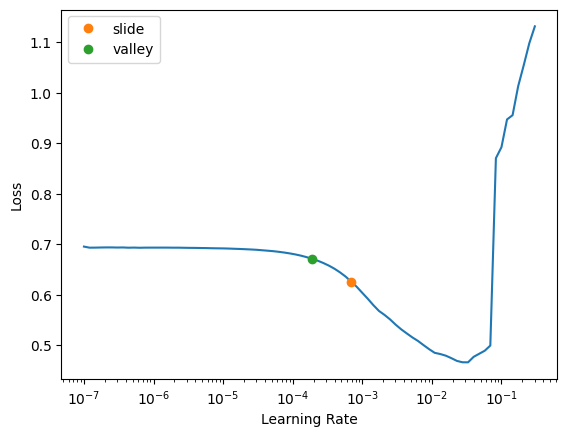

In [ ]:
learner.lr_find(suggest_funcs=[slide, valley])

In [ ]:
learner.fit_one_cycle(2,5e-4)


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.011024,0.003310,0.999413,00:41
1,0.006154,0.001897,0.999885,00:38


In [ ]:
learner.save("TV_Series-classifier-stage-0")

Path('models/TV_Series-classifier-stage-0.pth')

In [ ]:
# learner.load("book-classifier-stage-0")

Stage-1

In [ ]:
learner.unfreeze()

SuggestedLRs(slide=5.754399353463668e-06, valley=1.5848931980144698e-06)

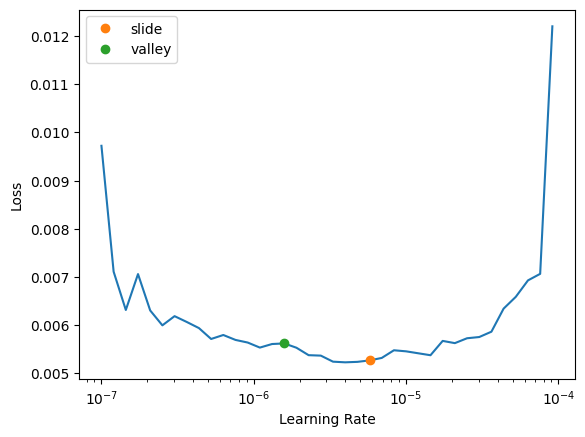

In [ ]:
learner.lr_find(suggest_funcs=[slide, valley])

In [ ]:
learner.fit_one_cycle(5, slice(1.6e-6, 5e-6))

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.004689,0.001523,0.999885,01:12
1,0.003066,0.001087,0.999914,01:06
2,0.002062,0.000870,0.999957,01:10
3,0.001832,0.000799,0.999957,01:05
4,0.001864,0.000782,0.999957,01:05


In [ ]:
learner.save("TV_Series-classifier-stage-1")

Path('models/TV_Series-classifier-stage-1.pth')

In [ ]:
learner.export("TV_Series-classifier-stage-1.pkl")